In [1]:
from dataset import *
from evaluator import *
from torch.utils.data import DataLoader

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import torch.autograd as autograd

from torchvision.utils import save_image, make_grid

import matplotlib.pyplot as plt

import tqdm

path = "./Auxiliary_DCGAN_WGANGP_compare_"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [2]:
image_size = 64

trans = transforms.Compose([transforms.ToPILImage(),
                            transforms.Resize([image_size, image_size]),
                            transforms.CenterCrop([image_size, image_size]),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5)), # normalize to [-1, 1] for the last layer of generator is tanh()
                            ])

# preprocessing size -> 64x64
train = ICLEVRLoader("./", trans=trans, mode="train", preprocessing=None)
# test = ICLEVRLoader("./", mode="test")

batch_size = 128 # based on paper
train_loader = DataLoader(
    dataset=train, 
    batch_size=batch_size,
    num_workers = 4
)

data = json.load(open(os.path.join('./','test.json')))
obj = json.load(open(os.path.join('./','objects.json')))
test_labels = data
for i in range(len(test_labels)):
    for j in range(len(test_labels[i])):
        test_labels[i][j] = obj[test_labels[i][j]]
    tmp = np.zeros(len(obj))
    tmp[test_labels[i]] = 1
    test_labels[i] = tmp
test_labels = torch.tensor(test_labels).to(device)

> Found 18009 images...


In [3]:
class Generator(nn.Module):
    def __init__(self, n_classes, latent_dim, img_shape, n_channels):
        super(Generator, self).__init__()
        
        self.n_classes = n_classes
        self.label_emb = nn.Embedding(n_classes, n_classes)
        self.input_cnn = nn.Linear(n_classes+latent_dim, 128)

        self.main = nn.Sequential(
            # input is Z, going into a convolution
#             nn.ConvTranspose2d( img_shape, img_shape*8 , 4, 1, 0, bias=False), #input shape [batch_size, 64, 1, 1]
            nn.ConvTranspose2d( 128, img_shape*8 , 4, 1, 0, bias=False), # input shape [batch_size, 64, 2, 2]
            nn.BatchNorm2d(img_shape*8),
            nn.ReLU(True),
            # state size. (img_shape*8) x 4 x 4
            nn.ConvTranspose2d(img_shape * 8, img_shape * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_shape * 4),
            nn.ReLU(True),
            # state size. (img_shape*4) x 8 x 8
            nn.ConvTranspose2d( img_shape * 4, img_shape * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_shape * 2),
            nn.ReLU(True),
            # state size. (img_shape*2) x 16 x 16
            nn.ConvTranspose2d( img_shape * 2, img_shape, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_shape),
            nn.ReLU(True),
            # state size. (img_shape) x 32 x 32
            nn.ConvTranspose2d( img_shape, n_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (n_channels) x 64 x 64
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((labels, noise), -1).float()
        gen_input = self.input_cnn(gen_input).view(-1, 128, 1, 1)
        img = self.main(gen_input)
        return img


class Discriminator(nn.Module):
    def __init__(self, n_classes, img_shape):
        super(Discriminator, self).__init__()
        self.n_classes = n_classes
        self.img_shape= img_shape
        self.label_embedding = nn.Embedding(n_classes, n_classes)
        
        self.label_linear = nn.Linear(n_classes, img_shape*img_shape)        
        
        self.main = nn.Sequential(
            # input is (n_classes) x 64 x 64
            nn.Conv2d(3, img_shape, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (img_shape) x 32 x 32
            nn.Conv2d(img_shape, img_shape * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(img_shape * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (img_shape*2) x 16 x 16
            nn.Conv2d(img_shape * 2, img_shape * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(img_shape * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (img_shape*4) x 8 x 8
            nn.Conv2d(img_shape * 4, img_shape * 8, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(img_shape * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (img_shape*8) x 4 x 4
#             nn.Conv2d(img_shape * 8, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid()
        )
        
        # Output layers
        self.adv_layer = nn.Sequential(
            nn.Conv2d(img_shape * 8, 1, 4, 1, 0, bias=False), 
#             nn.Sigmoid()
        )
        self.aux_layer = nn.Sequential(
            nn.Linear(img_shape * 8 * 4 * 4, self.n_classes), 
            nn.Sigmoid()
        )

    def forward(self, img):
        # Concatenate label embedding and image to produce input
#         labels = self.label_linear(labels.float()).view(-1, 1, self.img_shape, self.img_shape)
#         d_in = torch.cat((img, labels), 1)
        out = self.main(img)

        validity = self.adv_layer(out).view(-1, 1)
        label = self.aux_layer(out.view(out.shape[0], -1))

        return validity, label

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# loss function
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.BCELoss()

# model 
n_classes = 24
latent_dim = 100
img_shape = 64
n_channels = 3
load = False
if load:
    generator = torch.load("./Auxiliary_DCGAN_WGANGP_generator_epoch550.pt", map_location=device)
    discriminator = torch.load("./Auxiliary_DCGAN_WGANGP_discriminator_epoch550.pt", map_location=device)
else:
    generator = Generator(n_classes, latent_dim, img_shape, n_channels).to(device)
    discriminator = Discriminator(n_classes, img_shape).to(device)
    generator.apply(weights_init)
    discriminator.apply(weights_init)

# optimizer 
lr = 0.0002
b1 = 0.5
b2 = 0.999
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [5]:
def save_acc(filename, g_loss, d_loss, score):
    try:
        acc = np.load(filename)
        np_g_loss = acc['g_loss']
        np_d_loss = acc['d_loss']
        np_score = acc['score']
        np_g_loss = np.append(np_g_loss, g_loss)
        np_d_loss = np.append(np_d_loss, d_loss)
        np_score = np.append(np_score, score)
        np.savez(filename, g_loss=np_g_loss, d_loss=np_d_loss, score=np_score)
    except:
        g_loss = np.array(g_loss)
        d_loss = np.array(d_loss)
        score = np.array(score)
        np.savez(filename, g_loss=g_loss, d_loss=d_loss, score=score)
        
def test_eval(generator, epoch):
    np.random.seed(0)    
    generator.eval()
    eval_model = evaluation_model()
    batch_size = test_labels.shape[0]
    z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device) # shape [batch_size, latent_dim] with normal distribution
    gen_imgs = generator(z, test_labels) # shape [batch_size, 3, 64, 64]
    if epoch % 10 == 0:
        show_image(gen_imgs)
    return eval_model.eval(gen_imgs, test_labels)

def show_image(gen_imgs):
    # step 1: convert it to [0 ,2]
    gen_imgs = gen_imgs +1
    
    # step 2: convert it to [0 ,1]
    gen_imgs = gen_imgs - gen_imgs.min()
    gen_imgs = gen_imgs / (gen_imgs.max() - gen_imgs.min())
    
    grid = make_grid(gen_imgs)
    plt.figure(figsize=(14, 14))
    plt.imshow(np.transpose(grid.detach().cpu().numpy(), (1, 2, 0)))
    plt.show()

In [6]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    FloatTensor = torch.FloatTensor
    LongTensor = torch.LongTensor
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = FloatTensor(np.random.random((real_samples.size(0), 1, 1, 1))).to(device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    out, out_cls = D(interpolates)
    fake = Variable(FloatTensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False).to(device)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=out,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

[Epoch 1/100] [D loss: -7.704375] [G loss: 33.311543] [test score: 0.111111]
[Epoch 2/100] [D loss: -4.646090] [G loss: 12.862500] [test score: 0.138889]
[Epoch 3/100] [D loss: -4.010613] [G loss: 9.331875] [test score: 0.083333]
[Epoch 4/100] [D loss: -3.700612] [G loss: 8.612228] [test score: 0.069444]
[Epoch 5/100] [D loss: -3.255276] [G loss: 7.665816] [test score: 0.069444]
[Epoch 6/100] [D loss: -2.939019] [G loss: 7.795924] [test score: 0.055556]
[Epoch 7/100] [D loss: -2.771024] [G loss: 7.744594] [test score: 0.111111]
[Epoch 8/100] [D loss: -2.554188] [G loss: 7.265291] [test score: 0.083333]
[Epoch 9/100] [D loss: -2.342682] [G loss: 7.103435] [test score: 0.097222]


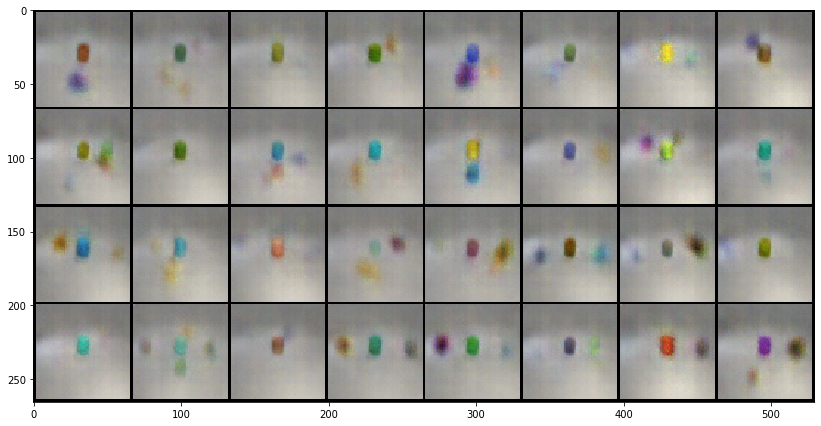

[Epoch 10/100] [D loss: -2.171974] [G loss: 7.120584] [test score: 0.069444]
[Epoch 11/100] [D loss: -2.055350] [G loss: 6.988325] [test score: 0.125000]
[Epoch 12/100] [D loss: -1.968065] [G loss: 7.202465] [test score: 0.111111]
[Epoch 13/100] [D loss: -1.900072] [G loss: 7.345000] [test score: 0.125000]
[Epoch 14/100] [D loss: -1.860468] [G loss: 6.730674] [test score: 0.097222]
[Epoch 15/100] [D loss: -1.822530] [G loss: 6.806638] [test score: 0.125000]
[Epoch 16/100] [D loss: -1.808648] [G loss: 6.750587] [test score: 0.166667]
[Epoch 17/100] [D loss: -1.811450] [G loss: 6.495434] [test score: 0.152778]
[Epoch 18/100] [D loss: -1.822961] [G loss: 6.406054] [test score: 0.166667]
[Epoch 19/100] [D loss: -1.816483] [G loss: 6.226987] [test score: 0.166667]


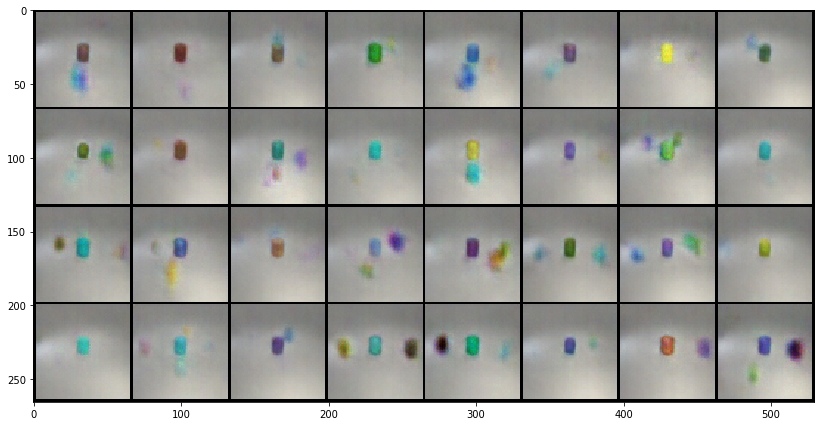

[Epoch 20/100] [D loss: -1.808510] [G loss: 6.174779] [test score: 0.194444]
[Epoch 21/100] [D loss: -1.834707] [G loss: 6.038450] [test score: 0.166667]
[Epoch 22/100] [D loss: -1.869862] [G loss: 6.268119] [test score: 0.208333]
[Epoch 23/100] [D loss: -1.895038] [G loss: 5.978940] [test score: 0.180556]
[Epoch 24/100] [D loss: -1.916533] [G loss: 5.616753] [test score: 0.277778]
[Epoch 25/100] [D loss: -1.894849] [G loss: 6.230434] [test score: 0.180556]
[Epoch 26/100] [D loss: -1.900021] [G loss: 5.912871] [test score: 0.222222]
[Epoch 27/100] [D loss: -1.928573] [G loss: 5.568681] [test score: 0.236111]
[Epoch 28/100] [D loss: -1.932582] [G loss: 5.621751] [test score: 0.180556]
[Epoch 29/100] [D loss: -1.942207] [G loss: 5.376181] [test score: 0.208333]


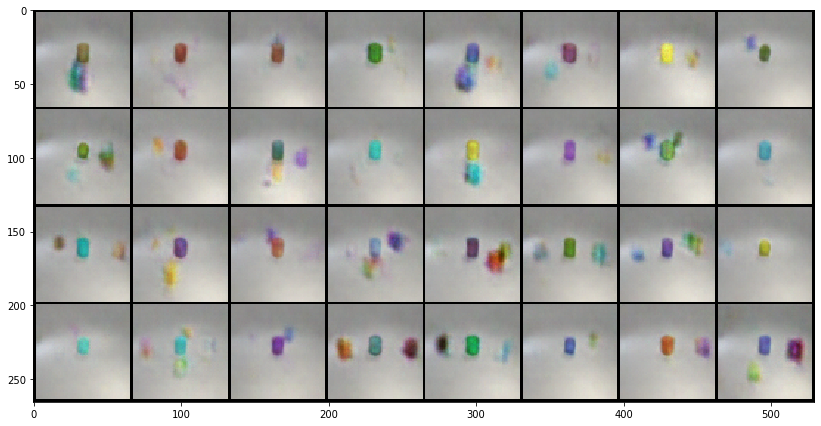

[Epoch 30/100] [D loss: -1.935007] [G loss: 5.576764] [test score: 0.250000]
[Epoch 31/100] [D loss: -1.949195] [G loss: 5.395529] [test score: 0.291667]
[Epoch 32/100] [D loss: -1.950620] [G loss: 5.332492] [test score: 0.208333]
[Epoch 33/100] [D loss: -1.956387] [G loss: 5.258127] [test score: 0.222222]
[Epoch 34/100] [D loss: -1.967921] [G loss: 5.171538] [test score: 0.250000]
[Epoch 35/100] [D loss: -1.983283] [G loss: 5.256766] [test score: 0.180556]
[Epoch 36/100] [D loss: -2.004273] [G loss: 5.145793] [test score: 0.236111]
[Epoch 37/100] [D loss: -2.011514] [G loss: 5.093148] [test score: 0.250000]
[Epoch 38/100] [D loss: -2.029689] [G loss: 5.163197] [test score: 0.222222]
[Epoch 39/100] [D loss: -2.034784] [G loss: 4.748634] [test score: 0.263889]


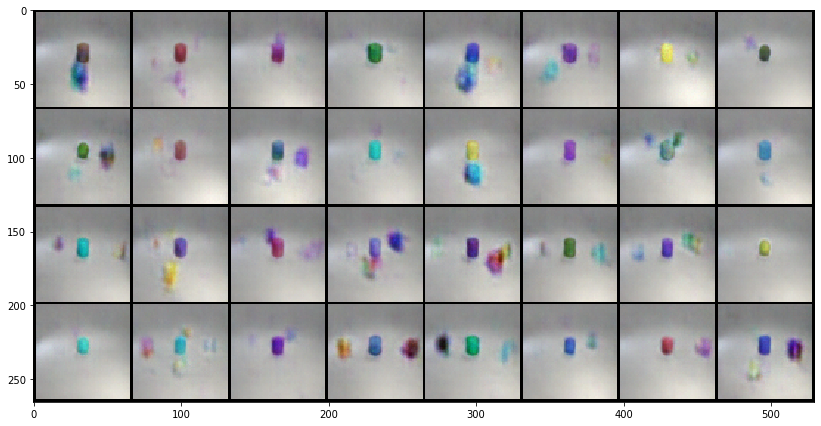

[Epoch 40/100] [D loss: -2.056390] [G loss: 4.710082] [test score: 0.222222]
[Epoch 41/100] [D loss: -2.077969] [G loss: 4.765823] [test score: 0.194444]
[Epoch 42/100] [D loss: -2.101771] [G loss: 4.859948] [test score: 0.194444]
[Epoch 43/100] [D loss: -2.097706] [G loss: 4.627151] [test score: 0.222222]
[Epoch 44/100] [D loss: -2.097445] [G loss: 4.478158] [test score: 0.208333]
[Epoch 45/100] [D loss: -2.095653] [G loss: 4.684223] [test score: 0.263889]
[Epoch 46/100] [D loss: -2.094071] [G loss: 4.513932] [test score: 0.277778]
[Epoch 47/100] [D loss: -2.109660] [G loss: 4.668045] [test score: 0.236111]
[Epoch 48/100] [D loss: -2.117518] [G loss: 4.498571] [test score: 0.263889]
[Epoch 49/100] [D loss: -2.114561] [G loss: 4.407937] [test score: 0.236111]


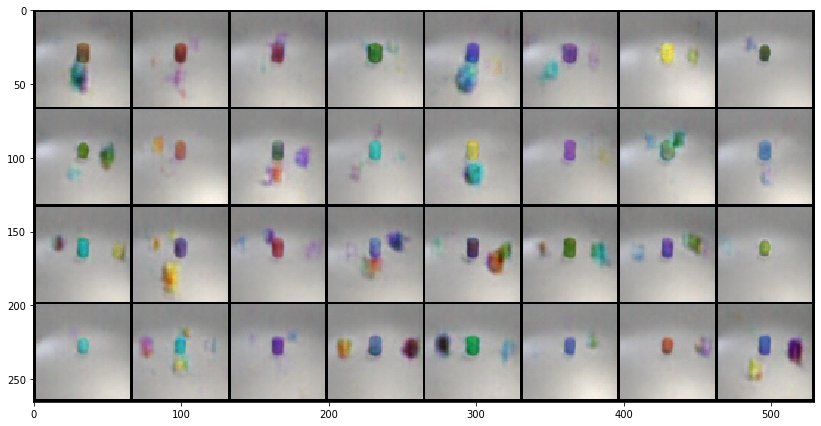

[Epoch 50/100] [D loss: -2.135496] [G loss: 4.735959] [test score: 0.180556]
[Epoch 51/100] [D loss: -2.150244] [G loss: 4.654950] [test score: 0.222222]
[Epoch 52/100] [D loss: -2.145664] [G loss: 4.292897] [test score: 0.222222]
[Epoch 53/100] [D loss: -2.151505] [G loss: 4.193198] [test score: 0.208333]
[Epoch 54/100] [D loss: -2.170836] [G loss: 4.214799] [test score: 0.208333]
[Epoch 55/100] [D loss: -2.183523] [G loss: 4.208738] [test score: 0.222222]
[Epoch 56/100] [D loss: -2.198187] [G loss: 4.336173] [test score: 0.208333]
[Epoch 57/100] [D loss: -2.206515] [G loss: 4.240723] [test score: 0.222222]
[Epoch 58/100] [D loss: -2.212698] [G loss: 4.028523] [test score: 0.250000]
[Epoch 59/100] [D loss: -2.236090] [G loss: 4.192629] [test score: 0.250000]


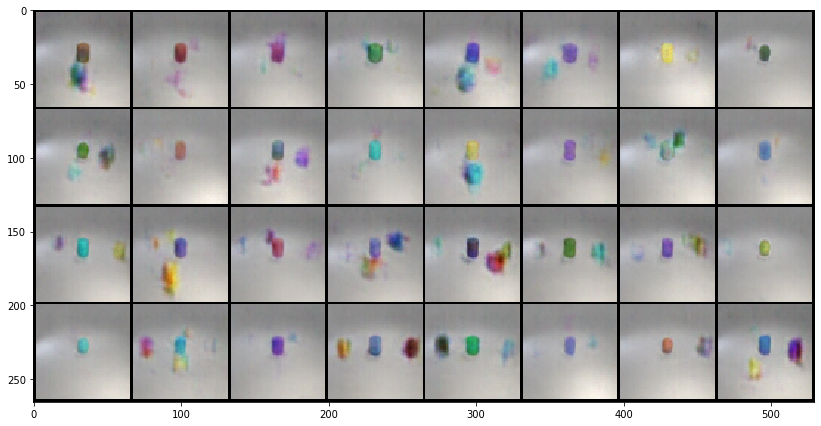

[Epoch 60/100] [D loss: -2.251251] [G loss: 4.313559] [test score: 0.236111]
[Epoch 61/100] [D loss: -2.257617] [G loss: 4.071297] [test score: 0.222222]
[Epoch 62/100] [D loss: -2.280448] [G loss: 4.207334] [test score: 0.236111]
[Epoch 63/100] [D loss: -2.285661] [G loss: 4.102842] [test score: 0.250000]
[Epoch 64/100] [D loss: -2.299006] [G loss: 4.181382] [test score: 0.208333]
[Epoch 65/100] [D loss: -2.290765] [G loss: 4.172691] [test score: 0.194444]
[Epoch 66/100] [D loss: -2.293270] [G loss: 4.059724] [test score: 0.194444]
[Epoch 67/100] [D loss: -2.292974] [G loss: 3.997044] [test score: 0.250000]
[Epoch 68/100] [D loss: -2.311487] [G loss: 4.305911] [test score: 0.222222]
[Epoch 69/100] [D loss: -2.319254] [G loss: 4.088697] [test score: 0.250000]


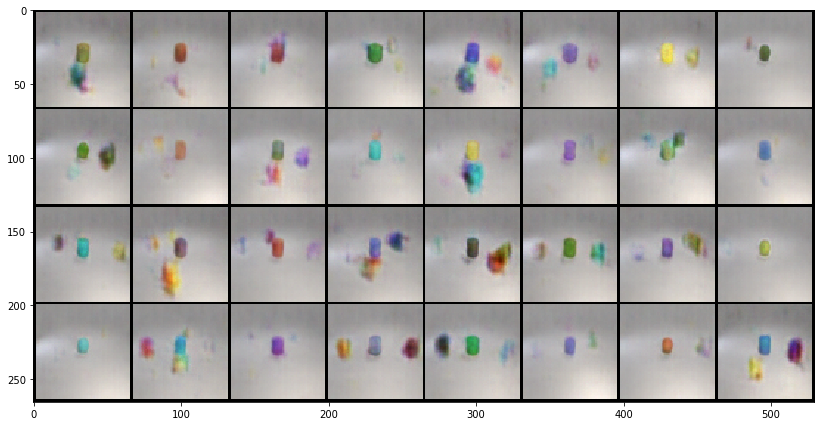

[Epoch 70/100] [D loss: -2.319885] [G loss: 4.124734] [test score: 0.291667]
[Epoch 71/100] [D loss: -2.330242] [G loss: 3.916252] [test score: 0.263889]
[Epoch 72/100] [D loss: -2.337200] [G loss: 3.985959] [test score: 0.236111]
[Epoch 73/100] [D loss: -2.347652] [G loss: 3.905158] [test score: 0.236111]
[Epoch 74/100] [D loss: -2.355095] [G loss: 3.868437] [test score: 0.263889]
[Epoch 75/100] [D loss: -2.367534] [G loss: 3.816930] [test score: 0.263889]
[Epoch 76/100] [D loss: -2.367636] [G loss: 3.666394] [test score: 0.263889]
[Epoch 77/100] [D loss: -2.371120] [G loss: 3.791322] [test score: 0.319444]
[Epoch 78/100] [D loss: -2.379841] [G loss: 3.827349] [test score: 0.250000]
[Epoch 79/100] [D loss: -2.392990] [G loss: 3.814408] [test score: 0.250000]


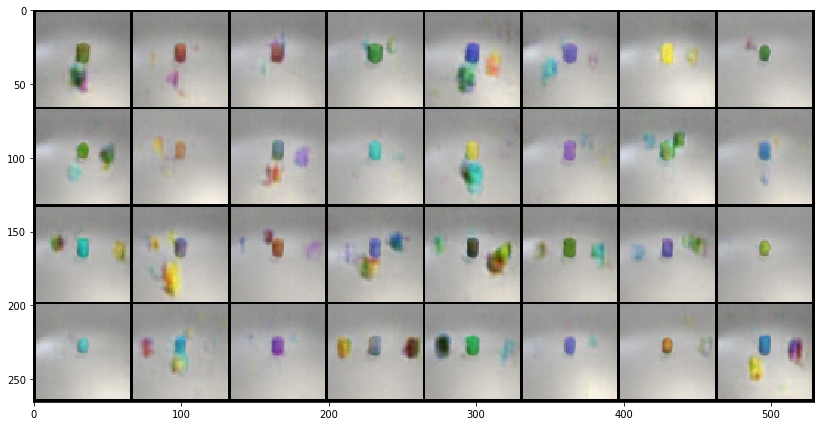

[Epoch 80/100] [D loss: -2.399036] [G loss: 3.800961] [test score: 0.277778]
[Epoch 81/100] [D loss: -2.399750] [G loss: 3.501485] [test score: 0.222222]
[Epoch 82/100] [D loss: -2.408753] [G loss: 3.616437] [test score: 0.208333]
[Epoch 83/100] [D loss: -2.414276] [G loss: 3.581635] [test score: 0.236111]
[Epoch 84/100] [D loss: -2.413735] [G loss: 3.454651] [test score: 0.236111]
[Epoch 85/100] [D loss: -2.420198] [G loss: 3.419119] [test score: 0.236111]
[Epoch 86/100] [D loss: -2.426914] [G loss: 3.537321] [test score: 0.208333]
[Epoch 87/100] [D loss: -2.443756] [G loss: 3.454105] [test score: 0.236111]
[Epoch 88/100] [D loss: -2.440010] [G loss: 3.605339] [test score: 0.277778]
[Epoch 89/100] [D loss: -2.442235] [G loss: 3.398971] [test score: 0.277778]


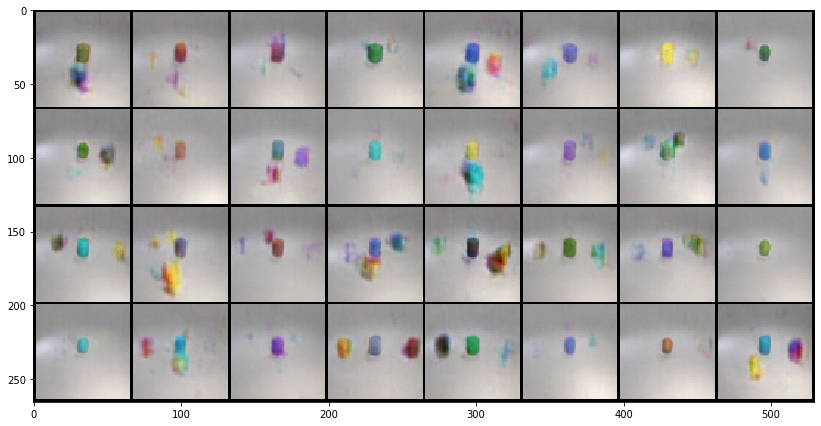

[Epoch 90/100] [D loss: -2.446563] [G loss: 3.439387] [test score: 0.277778]
[Epoch 91/100] [D loss: -2.457160] [G loss: 3.362441] [test score: 0.236111]
[Epoch 92/100] [D loss: -2.464821] [G loss: 3.424526] [test score: 0.236111]
[Epoch 93/100] [D loss: -2.459085] [G loss: 3.041127] [test score: 0.263889]
[Epoch 94/100] [D loss: -2.469747] [G loss: 3.169343] [test score: 0.236111]
[Epoch 95/100] [D loss: -2.468720] [G loss: 3.151925] [test score: 0.180556]
[Epoch 96/100] [D loss: -2.463799] [G loss: 2.959597] [test score: 0.222222]
[Epoch 97/100] [D loss: -2.476510] [G loss: 3.029244] [test score: 0.250000]
[Epoch 98/100] [D loss: -2.483606] [G loss: 3.037819] [test score: 0.250000]
[Epoch 99/100] [D loss: -2.489837] [G loss: 3.051406] [test score: 0.277778]


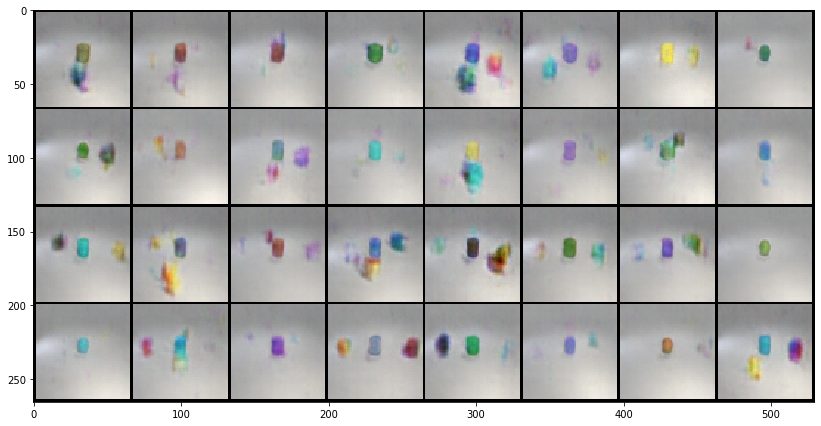

[Epoch 100/100] [D loss: -2.493260] [G loss: 2.993493] [test score: 0.236111]



In [7]:
# training 
epochs = 100
n_critic = 5 # number of training steps for discriminator per iter
lambda_gp = 10 # Loss weight for gradient penalty
lambda_cls = 5 # los weight for cls 
save = True
g_loss_list = []
d_loss_list = []
max_g_loss = np.inf
max_d_loss = -np.inf

FloatTensor = torch.FloatTensor
LongTensor = torch.LongTensor

for epoch in tqdm.notebook.tqdm(range(epochs)):
    total_d_loss = 0
    total_g_loss = 0
    generator.train()
    
    for i, (real_imgs, labels) in enumerate(train_loader):
        batch_size = real_imgs.shape[0]

        real_imgs = real_imgs[:, :3].to(device)
        real_labels = labels.to(device)
        
        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device) # shape [batch_size, latent_dim] with normal distribution
#         gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, (batch_size, 1)))) # shape [batch_size, 1] with 0~24
#         one_hot =  np.zeros((batch_size, n_classes))
#         one_hot[np.arange(batch_size), gen_labels] = 1
#         gen_labels = torch.from_numpy(one_hot).to(device)        
        
        # Generate a batch of images
        gen_imgs = generator(z, real_labels) # shape [batch_size, 3, 64, 64]
        
        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

         # Real images
        real_pred, real_aux = discriminator(real_imgs)
        d_real_loss = - torch.mean(real_pred)
        d_real_cls_loss = auxiliary_loss(real_aux, real_labels.float())
                
        # Fake images
        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        d_fake_loss = torch.mean(fake_pred)
        d_fake_cls_loss = auxiliary_loss(fake_aux, real_labels.float())
        
        # gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs, gen_imgs)
        
         # Total discriminator loss
        d_loss = d_real_loss + d_fake_loss + lambda_cls*d_real_cls_loss + lambda_gp*gradient_penalty
#         print( "   [Epoch %d/%d] [Iter %d/%d] [d_real_loss %f] [d_fake_loss %f] [d_real_cls_loss %f] [d_fake_cls_loss %f]"
#                 % (epoch+1, epochs, i, len(train_loader), d_real_loss, d_fake_loss, d_real_cls_loss, d_fake_cls_loss)
#             )
        
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        # Train the generator every n_critic steps
        if i % n_critic == 0:
            optimizer_G.zero_grad()

            # Loss measures generator's ability to fool the discriminator
            gen_imgs = generator(z, real_labels) # shape [batch_size, 3, 64, 64]
            
            # Loss measures generator's ability to fool the discriminator
            fake_validity, pred_label = discriminator(gen_imgs)
                        
            g_loss_fake = -torch.mean(fake_validity)
            g_loss_cls = auxiliary_loss(pred_label, real_labels.float())
            g_loss = g_loss_fake + lambda_cls * g_loss_cls
            
            g_loss.backward()
            optimizer_G.step()
        
        total_d_loss += d_loss.item()
        total_g_loss += g_loss.item()

    score = test_eval(generator, epoch+1)
    total_d_loss /= len(train_loader)
    total_g_loss /= (len(train_loader)/n_critic)
    
    print(
        "[Epoch %d/%d] [D loss: %f] [G loss: %f] [test score: %f]"
        % (epoch+1, epochs, total_d_loss, total_g_loss, score)
    )

    # loss save
    if save:
        save_acc(path+"loss.npz", total_g_loss, total_d_loss, score)
    else:
        g_loss_list.append(total_g_loss)
        d_loss_list.append(total_d_loss)
    
    if save:
        if max_g_loss > total_g_loss:
            max_g_loss = total_g_loss
            torch.save(generator, path+"generator.pt")
        if max_d_loss < total_d_loss:
            max_d_loss = total_d_loss
            torch.save(discriminator, path+"discriminator.pt")

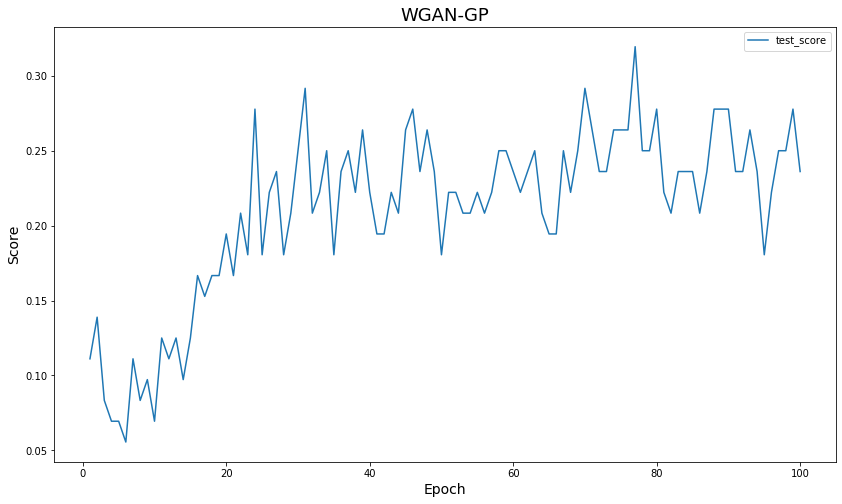

In [10]:
plt.figure(figsize=(14, 8))

load = True
if load:
    acc = np.load(path+"loss.npz")
    g_loss = acc['g_loss']
    d_loss = acc['d_loss']
    score = acc["score"]

plt.title("WGAN-GP", fontsize=18)
# plt.ylabel("Loss", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
x = np.arange(1, len(g_loss)+1)
# plt.plot(x, g_loss, label="g_loss")
# plt.plot(x, d_loss, label="d_loss")
plt.plot(x, score, label="test_score")
plt.legend()
plt.show()

In [ ]:
## evaluate
generator_load = torch.load(path+"generator.pt", map_location=device)
# generator_load2 = torch.load(path+"generator_epoch600.pt", map_location=device)
# generator_load.eval()

print(test_eval(generator_load, 0))
# print(test_eval(generator_load2, 0))
print(test_eval(generator, 0))

In [ ]:
eval_model = evaluation_model()
for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)
    out = F.interpolate(images, size=64)  #The resize operation on tensor.
    print(out.shape)
    print(eval_model.eval(images[:, :3], labels))
#     grid = make_grid(out)
    break

In [ ]:
img, label = train.__getitem__(0)
 # step 1: convert it to [0 ,2]
img = img +1

 # step 2: convert it to [0 ,1]
img = img - img.min()
img = img / (img.max() - img.min())

print(img.shape)
plt.imshow(np.transpose(img,(1,2,0)))